In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive.zip -d /content/drive/MyDrive

Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/drive/MyDrive/video_game_reviews.csv  


In [3]:
import pandas as pd

# Load the video game reviews dataset
try:
    # Make sure your file is accessible at this path in your environment
    df = pd.read_csv('/content/drive/MyDrive/video_game_reviews.csv')
    print("--- Video game dataset loaded successfully! ---")
except FileNotFoundError:
    print("Error: 'video_game_reviews.csv' not found. Please ensure the file is uploaded and the path is correct.")
    exit()

# Display basic information about the columns
print("\n--- DataFrame Info ---")
df.info()

# Use the correct column name 'User Rating' to check its distribution
print("\n--- User Rating Stats ---")
print(df['User Rating'].describe())

--- Video game dataset loaded successfully! ---

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47774 entries, 0 to 47773
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Game Title               47774 non-null  object 
 1   User Rating              47774 non-null  float64
 2   Age Group Targeted       47774 non-null  object 
 3   Price                    47774 non-null  float64
 4   Platform                 47774 non-null  object 
 5   Requires Special Device  47774 non-null  object 
 6   Developer                47774 non-null  object 
 7   Publisher                47774 non-null  object 
 8   Release Year             47774 non-null  int64  
 9   Genre                    47774 non-null  object 
 10  Multiplayer              47774 non-null  object 
 11  Game Length (Hours)      47774 non-null  float64
 12  Graphics Quality         47774 non-null  object 
 13  Soun

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- 1. Data Cleaning and Preparation (with Dynamic Thresholds) ---
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

df.dropna(subset=['User Review Text', 'User Rating'], inplace=True)

# Use quantiles to automatically find fair thresholds for the 0-100 rating scale
low_threshold = df['User Rating'].quantile(0.33)
high_threshold = df['User Rating'].quantile(0.66)

print(f"\n--- Dynamically Calculated Rating Thresholds ---")
print(f"Negative reviews will be below: {low_threshold:.2f}")
print(f"Neutral reviews will be between: {low_threshold:.2f} and {high_threshold:.2f}")
print(f"Positive reviews will be above: {high_threshold:.2f}")

def map_sentiment_dynamic(rating):
    rating = float(rating)
    if rating >= high_threshold:
        return 'positive'
    elif rating >= low_threshold:
        return 'neutral'
    else:
        return 'negative'

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    stop_words = set(stopwords.words('english'))
    negation_words = {'not', 'no', 'nor'}
    stop_words = stop_words - negation_words
    text = re.sub(r"[^a-zA-Z]", " ", text).lower()
    tokens = text.split()
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(clean_tokens)

print("\n--- Preparing data for sentiment analysis ---")
df['sentiment'] = df['User Rating'].apply(map_sentiment_dynamic)
df['clean_text'] = df['User Review Text'].apply(preprocess_text)
print("Sentiment labels and cleaned text created.")

# --- 2. Create a Balanced Dataset using Undersampling ---
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']
df_neutral = df[df['sentiment'] == 'neutral']

sample_size = min(len(df_positive), len(df_negative), len(df_neutral))
df_positive_downsampled = df_positive.sample(sample_size, random_state=42)
df_negative_downsampled = df_negative.sample(sample_size, random_state=42)
df_neutral_downsampled = df_neutral.sample(sample_size, random_state=42)

df_balanced = pd.concat([df_positive_downsampled, df_negative_downsampled, df_neutral_downsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("\n--- Balanced Dataset Distribution ---")
print(df_balanced['sentiment'].value_counts())

# --- 3. Train the Sentiment Model on Balanced Data ---
X = df_balanced['clean_text']
y = df_balanced['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

sentiment_model = LogisticRegression(max_iter=1000)
sentiment_model.fit(X_train_vec, y_train)

print("\n--- Sentiment Model Evaluation Report ---")
y_pred = sentiment_model.predict(X_test_vec)
print(classification_report(y_test, y_pred))


--- Dynamically Calculated Rating Thresholds ---
Negative reviews will be below: 26.20
Neutral reviews will be between: 26.20 and 33.00
Positive reviews will be above: 33.00

--- Preparing data for sentiment analysis ---
Sentiment labels and cleaned text created.

--- Balanced Dataset Distribution ---
sentiment
negative    15702
positive    15702
neutral     15702
Name: count, dtype: int64

--- Sentiment Model Evaluation Report ---
              precision    recall  f1-score   support

    negative       0.33      0.34      0.34      3140
     neutral       0.34      0.25      0.29      3141
    positive       0.33      0.41      0.36      3141

    accuracy                           0.33      9422
   macro avg       0.33      0.33      0.33      9422
weighted avg       0.33      0.33      0.33      9422




--- Generating Word Cloud for Most Common Words ---


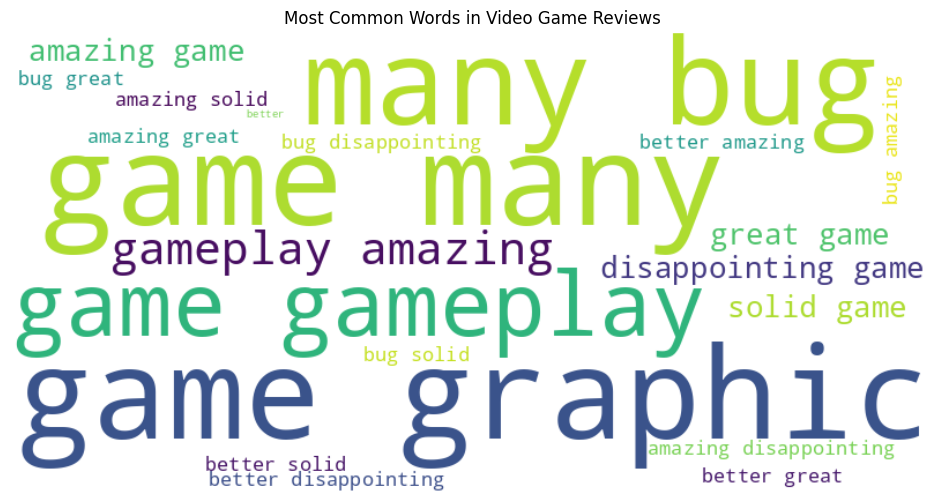


--- Starting Topic Modeling with LDA ---
LDA model training complete.

--- Top Words for Each Discovered Topic ---
Topic #1:
amazing gameplay solid great disappointing bug graphic better
Topic #2:
amazing gameplay disappointing great bug solid graphic better
Topic #3:
amazing bug great disappointing solid graphic better gameplay
Topic #4:
great graphic better amazing disappointing bug solid gameplay
Topic #5:
disappointing bug amazing great solid graphic better gameplay
Topic #6:
graphic better disappointing amazing great bug solid gameplay
Topic #7:
solid graphic better amazing great disappointing bug gameplay
Topic #8:
bug solid great amazing disappointing graphic better gameplay


In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- 1. Find the Most Common Words (Word Cloud) ---
print("\n--- Generating Word Cloud for Most Common Words ---")
full_text = " ".join(review for review in df['clean_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(full_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Video Game Reviews")
plt.show()

# --- 2. Topic Modeling with LDA ---
print("\n--- Starting Topic Modeling with LDA ---")
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
dtm = count_vectorizer.fit_transform(df['clean_text'].dropna())
lda = LatentDirichletAllocation(n_components=8, random_state=42)
lda.fit(dtm)
print("LDA model training complete.")

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\n--- Top Words for Each Discovered Topic ---")
display_topics(lda, count_vectorizer.get_feature_names_out(), 10)

In [6]:
# --- Classifying New Sentences into Topics ---
def predict_topic(text, count_vectorizer, lda_model):
    clean_text = preprocess_text(text)
    vectorized_text = count_vectorizer.transform([clean_text])
    topic_probability = lda_model.transform(vectorized_text)
    most_likely_topic = topic_probability.argmax()
    return most_likely_topic + 1

new_review_1 = "The story was amazing and the characters were well-developed."
new_review_2 = "This game is full of bugs and glitches, it keeps crashing."

topic_1 = predict_topic(new_review_1, count_vectorizer, lda)
topic_2 = predict_topic(new_review_2, count_vectorizer, lda)

print(f"\n--- Classifying New Sentences ---")
print(f"'{new_review_1}' belongs to Topic #{topic_1}")
print(f"'{new_review_2}' belongs to Topic #{topic_2}")


--- Classifying New Sentences ---
'The story was amazing and the characters were well-developed.' belongs to Topic #3
'This game is full of bugs and glitches, it keeps crashing.' belongs to Topic #8


In [7]:
import pickle
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# --- Save the Sentiment Model and TF-IDF Vectorizer ---
# Use filenames that specify this is for the video game (vg) dataset
with open('models/sentiment_model_vg.pkl', 'wb') as f:
    pickle.dump(sentiment_model, f)
with open('models/tfidf_vectorizer_vg.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# --- Save the LDA Model and the CountVectorizer ---
with open('models/lda_model_vg.pkl', 'wb') as f:
    pickle.dump(lda, f)
with open('models/count_vectorizer_vg.pkl', 'wb') as f:
    pickle.dump(count_vectorizer, f)

print("✅ All video game models and vectorizers have been saved to the 'models/' folder.")

✅ All video game models and vectorizers have been saved to the 'models/' folder.


In [8]:
import sklearn
import numpy
import pandas

print(f"Scikit-learn version: {sklearn.__version__}")
print(f"NumPy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")

Scikit-learn version: 1.6.1
NumPy version: 2.0.2
Pandas version: 2.2.2
